### Introduction

This notebook shows the basic functionality of the `masserstein` package.  
We cover simulations of theoretical spectra from chemical formulas, simulating experimental spectra with measurement inaccuracies, and regression of experimental spectra agains theoretical ones.  

In [37]:
# do not run the cell below if figures are to be saved in files:

In [38]:
%matplotlib notebook  

### Package imports

In [39]:
from copy import deepcopy
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt

### Generating theoretical spectra from amino acid sequences

In [40]:
myoglobin ="""GLSDGEWQLVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASE
DLKKHGATVLTALGGILKKKGHHEAEIKPLAQSHATKHKIPVKYLEFISECIIQVLQSKH
PGDFGADAQGAMNKALELFRKDMASNYKELGFQG"""
haemoglobinB = """VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPK
VKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFG
KEFTPPVQAAYQKVVAGVANALAHKYH"""
haemoglobinA = """VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHG
KKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTP
AVHASLDKFLASVSTVLTSKYR"""

Convert the protein sequences to chemical formulas:

In [41]:
from masserstein import peptides
haemoglobinA_formula = peptides.get_protein_formula(haemoglobinA)
haemoglobinB_formula = peptides.get_protein_formula(haemoglobinB)
myoglobin_formula = peptides.get_protein_formula(myoglobin)

Generate theoretical spectra:

In [42]:
from masserstein import Spectrum
hA19 = Spectrum(haemoglobinA_formula, charge=19, adduct='H', label='hA 19+')
hA20 = Spectrum(haemoglobinA_formula, charge=20, adduct='H', label='hA 20+')
hA21 = Spectrum(haemoglobinA_formula, charge=21, adduct='H', label='hA 21+')
hB20 = Spectrum(haemoglobinB_formula, charge=20, adduct='H', label='hB 20+')
hB21 = Spectrum(haemoglobinB_formula, charge=21, adduct='H', label='hB 21+')
hB22 = Spectrum(haemoglobinB_formula, charge=22, adduct='H', label='hB 22+')
m21  = Spectrum(myoglobin_formula, charge=21, adduct='H', label='myo 21+')
m22  = Spectrum(myoglobin_formula, charge=22, adduct='H', label='myo 22+')
m23  = Spectrum(myoglobin_formula, charge=23, adduct='H', label='myo 23+')
m24  = Spectrum(myoglobin_formula, charge=24, adduct='H', label='myo 24+')
spectra = [hA19, hA20, hA21, hB20, hB21, hB22, m21, m22, m23, m24]

Sort the spectra according to m/z of the monoisotopic peak:

In [43]:
spectra.sort(key = lambda x: x.confs[0][0])
k = len(spectra)

Show all the generated spectra:

<IPython.core.display.Javascript object>


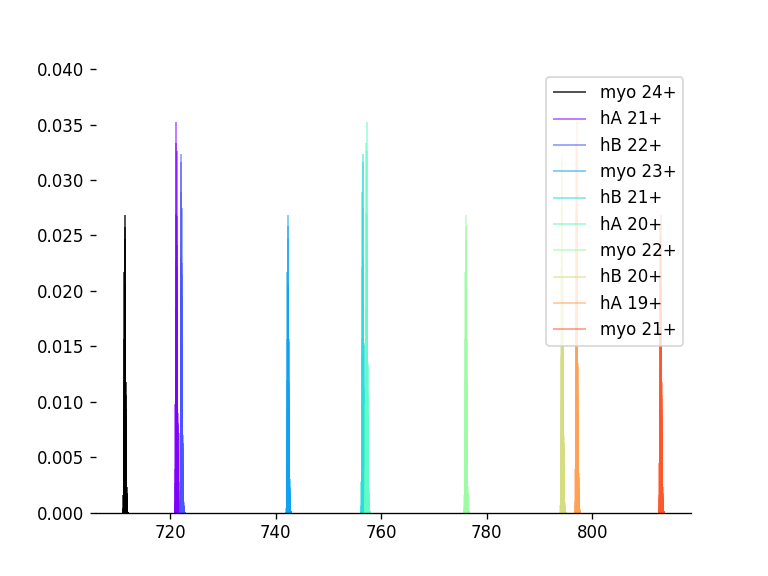

In [44]:
fig = plt.figure()
ax = fig.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.ylim(0, 0.04)
Spectrum.plot_all(spectra)

Normalize all the spectra so that peak intensities sum up to 1:

In [45]:
for s in spectra:
    s.normalize()

Show individual theoretical spectra:

<IPython.core.display.Javascript object>


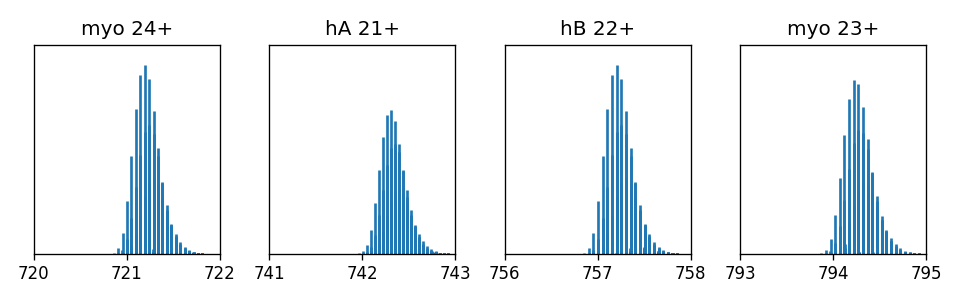

In [46]:
fig = plt.figure(figsize=(8, 2.5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    s = spectra[2*i+1]
    s.plot(show=False, linewidth=1.6)
    ax = fig.gca()
    #ax.spines["top"].set_visible(False)
    #ax.spines["right"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.ylim(0, 0.04)
    ticks = np.arange(int(s.confs[0][0]), round(s.confs[-1][0])+1, step=1)
    ax.set_xticks(ticks)
    plt.title(spectra[i].label)
    #plt.xticks(rotation=330)
plt.tight_layout()
# plt.savefig(fname='hemoglobin_library.png', dpi=240)

### Simulating an experimental spectrum

Now, we will mix the theoretical spectra and add some noise to simulate an "experimental" spectrum that we will use as an input to our regression method.  
First, we generate a linear combination of the theoretical spectra

In [47]:
proportions = [1, 2, 1.2, 0.5, 0.9, 0.6, 0.2, 0.3, 0.4, 0.]
proportions = [p/sum(proportions) for p in proportions]

In [48]:
convolved = Spectrum(label='Convolved')
for s, p in zip(spectra, proportions):
    convolved += s*p

<IPython.core.display.Javascript object>


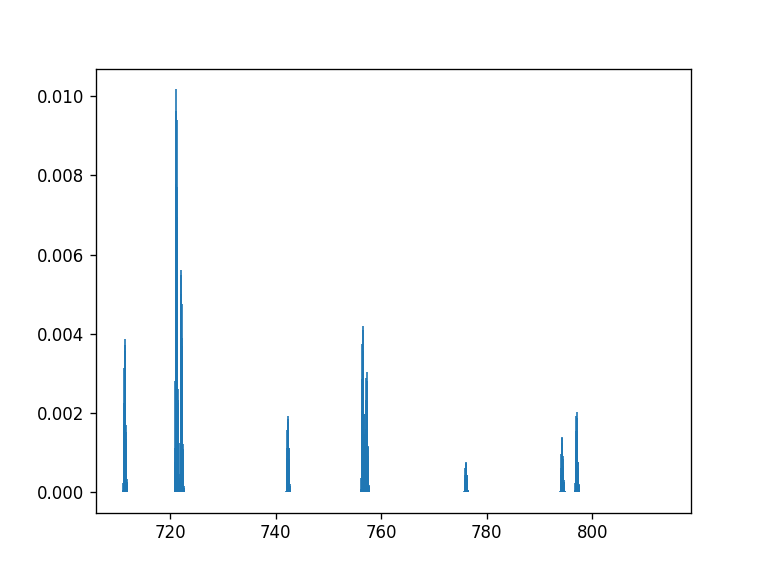

In [49]:
plt.figure()
convolved.plot()

Now, we add some background noise - 100 randomly distributed peaks that amount for 10% of the total intensity. 

In [50]:
convolved.add_chemical_noise(100, 0.1)

<IPython.core.display.Javascript object>


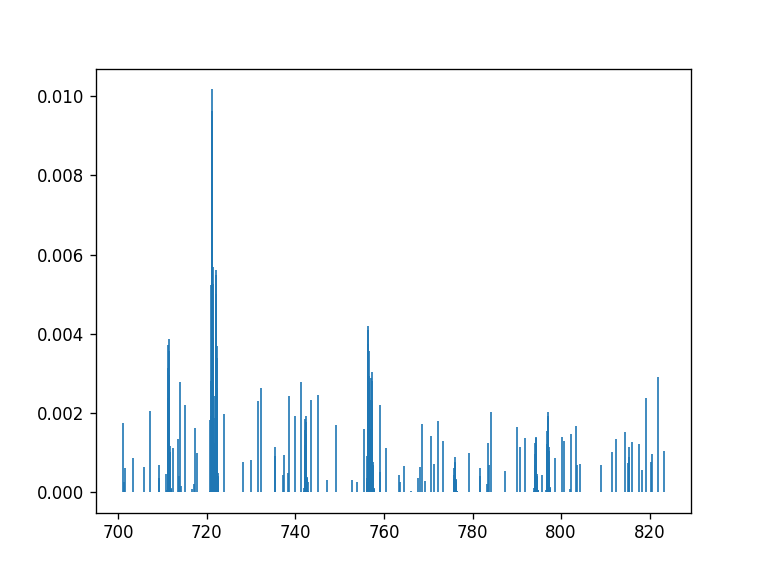

In [51]:
plt.figure()
convolved.plot()

We generate a profile spectrum by applying a Gaussian distribution to each peak.  

In [53]:
len(convolved.confs)

12074

In [54]:
convolved.gaussian_smoothing(0.01, 0.001)

<IPython.core.display.Javascript object>


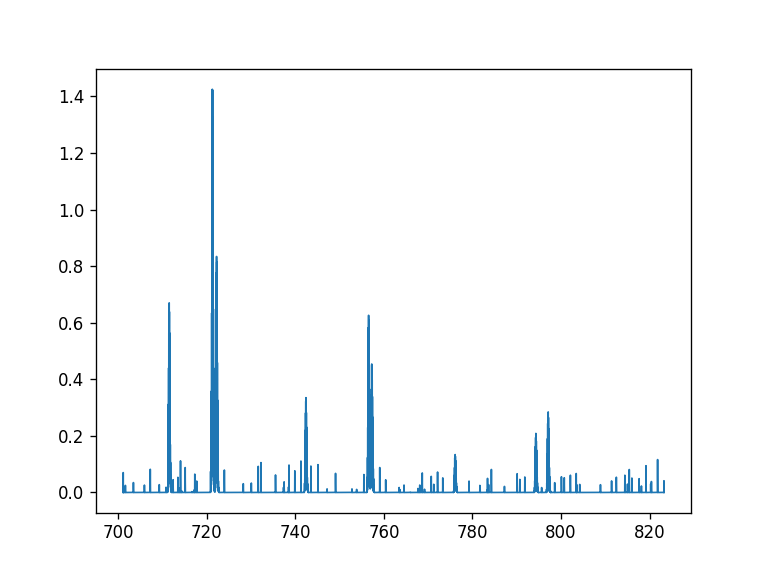

In [55]:
plt.figure()
convolved.plot(profile=True)

We aditionally add Gaussian noise to each intensity measurement to simulate electronic noise.  
This gives us our "experimental" spectrum that we will use to demonstrate the regression method.  

In [56]:
convolved.add_gaussian_noise(0.01)

<IPython.core.display.Javascript object>


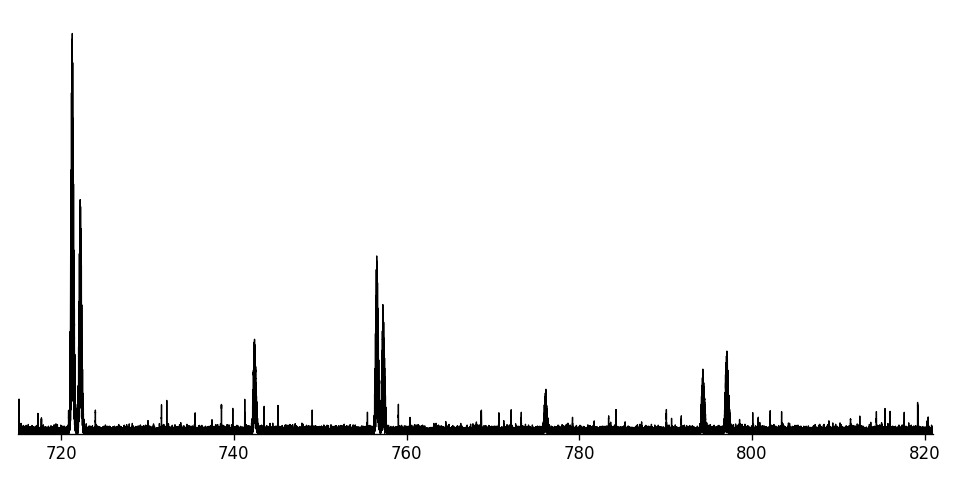

In [57]:
fig = plt.figure(figsize=(8,4))
convolved.plot(profile=True, color='black', linewidth=0.8)
ax = fig.gca()
ax.get_yaxis().set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.ylim(0, 1.5)
plt.xlim(715, 821)
plt.tight_layout()

Compare theoretical and observed peaks of hemoglobin A 20+:

In [ ]:
peaks = sp.signal.argrelmax(np.array([i for m, i in convolved.confs]), order=21)[0]
peaks = [convolved.confs[i] for i in peaks]

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.subplot(221)
convolved.plot(profile=True, show=False, color='black', linewidth=1)
plt.plot(*zip(*peaks), 'r.', ms=10)
plt.title('Simulated experimental spectrum')
ax = fig.gca()
ax.get_yaxis().set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.ylim(0, .5)
plt.xlim(756.9, 757.8)
plt.tight_layout()
#fig.set_canvas(plt.gcf().canvas)

plt.subplot(222)
convolved.plot(profile=True, show=False, color='black', linewidth=1.8)
plt.plot(*zip(*peaks), 'r.', ms=10)
plt.title('Selected experimental peak')
ax = fig.gca()
ax.get_yaxis().set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.ylim(.3, .45)
plt.xlim(757.246, 757.259)
plt.tight_layout()
#fig.set_canvas(plt.gcf().canvas)

plt.subplot(223)
thr = deepcopy(hA20)
thr.coarse_bin(2)
thr.plot(show=False, linewidth=1.4)
plt.title('Simulated theoretical spectrum')
ax = fig.gca()
ax.get_yaxis().set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.xlim(756.9, 757.8)
plt.tight_layout()

plt.subplot(224)
thr = deepcopy(hA20)
thr.coarse_bin(2)
plt.title('Selected theoretical peak')
thr.plot(show=False, linewidth=1.8)
ax = fig.gca()
ax.get_yaxis().set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.xlim(757.246, 757.259)
plt.tight_layout()




Red dots highlight maxima of intensity.  
Note that the signal maximum of the selected peak doesn't match its theoretical counterpart due to simulated measurement inaccuracies. This will be handled by our regression method through the use of the optimal transport theory.  

### Regression of mass spectra

In [ ]:
from masserstein import estimate_proportions

The `masserstein` package in its current implementation requires that all the intensity measurements sum up to 1, regardless whether the spectra are in centroided or profile mode.  
Therefore, as a first step, we normalize the spectrum.  
Note that this normalization is not correct from a chemical point of view, because we use a sum of intensities instead of peak areas. However, this is required to get correct results from `masserstein`. 

In [ ]:
convolved.normalize()

Now we regress the "experimental" spectrum agains the theoretical ones to estimate their proportions (i.e. the amounts of the experimental ion current that match each theoretical spectrum). We will use a 0.05 Da tolerance for matching experimental and theoretical masses. 

In [ ]:
res = estimate_proportions(convolved, spectra, MTD=0.05)

In [ ]:
print('True:', 'Estimate:', sep='\t')
for e, p in zip(res['proportions'], proportions):
    print(round(p, 3), round(e/sum(res['proportions']), 3), sep='\t')

We can also centroid our experimental spectrum and compare results.  

In [ ]:
peaks, _ = convolved.centroid(peak_height_fraction=0.5, max_width=0.03)

Show the first few detected peaks (typically corresponding to background noise):

In [ ]:
peaks[:5]

Generate a new spectrum based on the computed peaks:

In [ ]:
centroided = Spectrum(confs=peaks)

In [ ]:
plt.figure()
plt.subplot(121)
plt.title('Profile mode')
convolved.plot(profile=True, show=False)
plt.subplot(122)
plt.title('Centroid mode')
centroided.plot(show=False)
plt.tight_layout()

Regress the centroided spectrum against the theoretical spectra:

In [ ]:
centroided.normalize()

In [ ]:
res2 = estimate_proportions(centroided, spectra, MTD=0.05)

In [ ]:
print('True:', 'Estimate:', sep='\t')
for e, p in zip(res2['proportions'], proportions):
    print(round(p, 3), round(e/sum(res2['proportions']), 3), sep='\t')

We get similar results for this spectrum in both profile and centroided modes.  